# Датасет - данные о пользователях Т-инвестиций

## Исследовательский вопрос: как взаимосвязаны характеристики клиента и его активности на бирже, как выглядит идеальный клиент для бизнеса?

Изначально хотелось бы вообще узнать, что выгодно для брокера? Как брокеры зарабатывают. Это поможет мне понять на что обращать внимание.

Основной доход брокера - комиссионные. Т.е. чем выше обороты клиента, тем он выгоднее брокеру.
При этом можно предположить, что если сделки успешные, то клиент выгоднее, ибо скорее всего продолжит пользоваться брокерскими услугами.
Далее маржинальная торговля и торговля фьючерсами, а также вклады инвестиции в фонды Т-Капитала. 

Теперь я изучу данные, сделаю первые выводы и гепотезы.

### Обработка данных, предварительный анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('invest_db.csv', sep=';')

In [3]:
df.head()

,id,date,age,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,invest_utilization_dt,forts_flg,margin_status_flg,...,portf_fnd_amt,portf_opt_amt,portf_ore_amt,ccr_balance_amt,cor_balance_amt,lon_balance_amt,posts,comments,reacts,reads
0,1479787897,2024-04-20,33,NaN,UNM,"0,0","31272,0",2023-09-13,1,0,...,"428,0","0,0","0,0","-11298,0","541,0","0,0","0,0","0,0","0,0","0,0"
1,601760063,2024-02-01,29,GRD,UNM,"0,0","6284,0",2021-03-29,0,0,...,"23,0","0,0","0,0",NaN,"8115,0","0,0","0,0","0,0","0,0","0,0"
2,61175329,2024-02-10,38,SCH,MAR,"0,0","1904,0",2023-12-05,1,0,...,"193,0","0,0","0,0","0,0","25,0",NaN,"0,0","0,0","0,0","2,0"
3,1411700618,2024-03-05,64,NaN,NaN,"0,0",NaN,2021-09-16,0,0,...,"0,0","0,0","0,0",NaN,"65,0",NaN,"0,0","0,0","0,0","0,0"
4,2096755145,2024-02-10,31,NaN,UNM,"0,0",NaN,2022-03-01,0,0,...,"0,0","0,0","0,0","0,0","0,0",NaN,"0,0","0,0","0,0","0,0"


In [4]:
df.shape

(458370, 51)

In [5]:
df['id'].value_counts().describe()

count    5093.0
mean       90.0
std         0.0
min        90.0
25%        90.0
50%        90.0
75%        90.0
max        90.0
Name: count, dtype: float64

Для каждого клиента ровно 90 записей

In [6]:
df['date'] = pd.to_datetime(df['date']) 
df['invest_utilization_dt'] = pd.to_datetime(df['invest_utilization_dt'])

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
missing = (df.isna().sum() / len(df))
missing = missing[missing > 0]
missing

education_level_cd    0.490673
marital_status_cd     0.417436
children_cnt          0.104850
monthly_income_amt    0.225211
ccr_balance_amt       0.364396
cor_balance_amt       0.002317
lon_balance_amt       0.676019
posts                 0.042149
comments              0.042149
reacts                0.042149
reads                 0.042149
dtype: float64

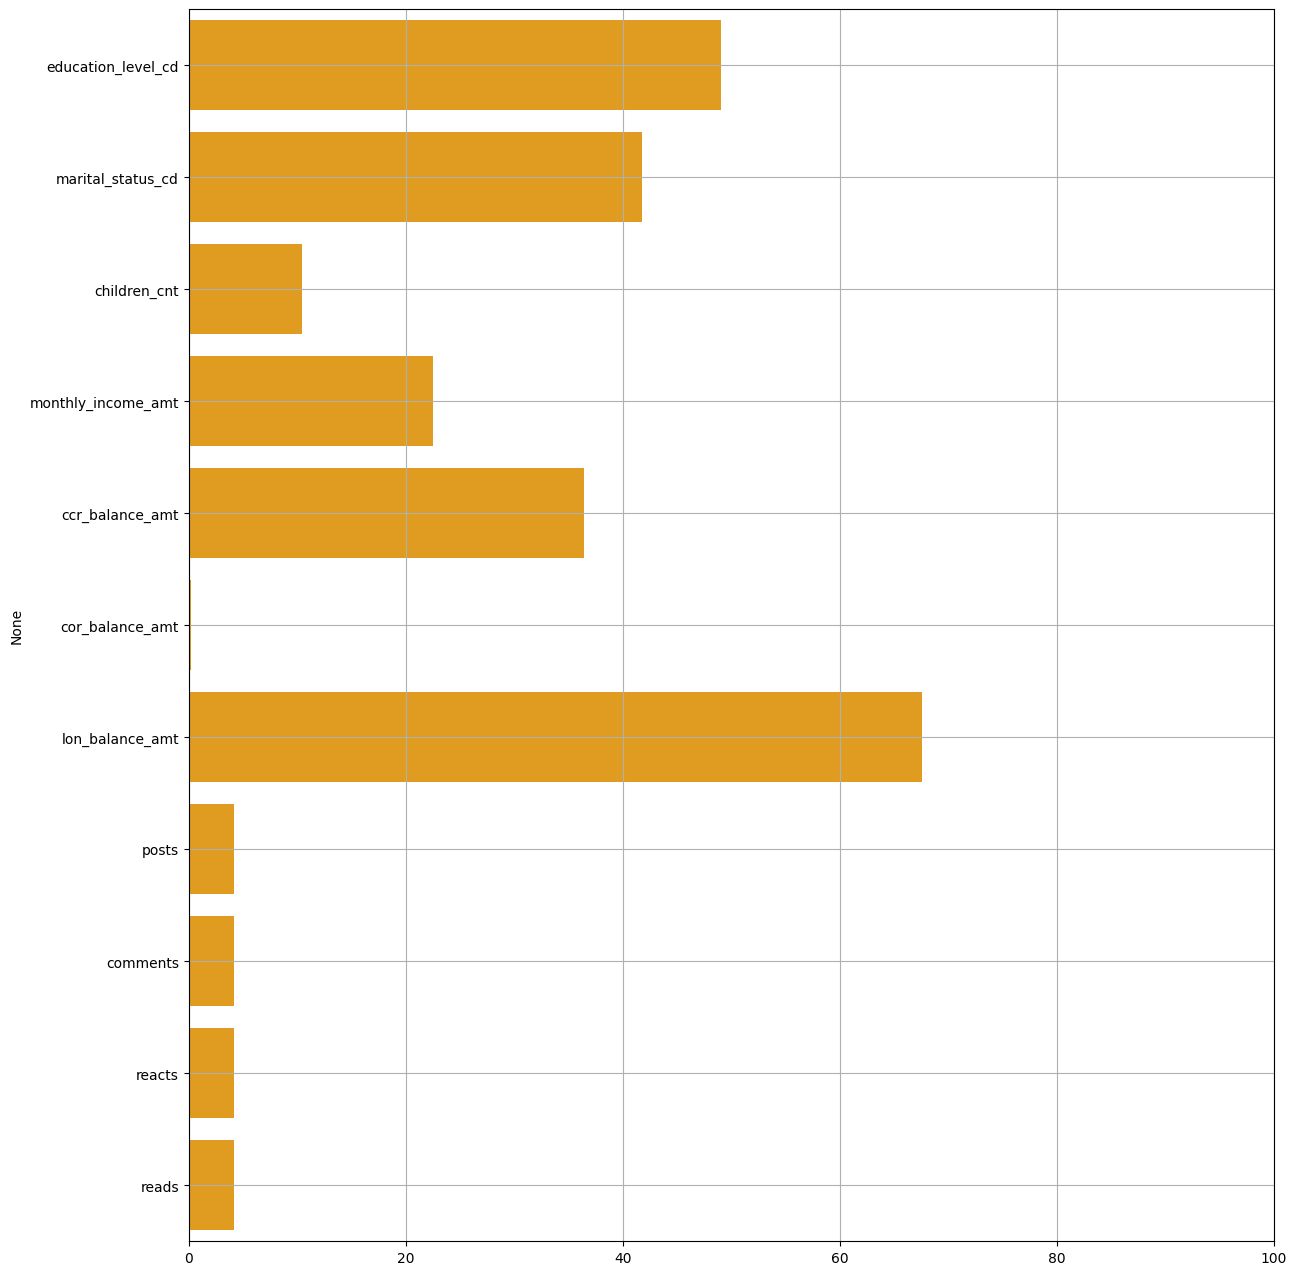

In [9]:
missing_percent = round((df.isna().sum() / len(df)) * 100, 2)
missing_percent = missing_percent[missing_percent > 0]

missing_percent

plt.figure(figsize=(14, 16))

sns.barplot(x=missing_percent.values, y=missing_percent.index, color='orange')

plt.xlim(0, 100)
plt.grid()
plt.show()

In [10]:
all_nan_mask = df[['posts', 'comments', 'reacts', 'reads']].isna().all(axis=1)
num_all_nan = len(df[all_nan_mask])

print(f"Количество строк, где все четыре столбца posts, comments, reacts, reads = NaN: {num_all_nan}")

Количество строк, где все четыре столбца posts, comments, reacts, reads = NaN: 19320


In [11]:
df['posts'].isna().sum()

np.int64(19320)

Т.е. информации об активности в сообществе нет у одних и тех же клиентов.

In [12]:
df.describe()

,id,date,age,invest_utilization_dt,forts_flg,margin_status_flg,qualified_investor_flg
count,4.583700e+05,458370,458370.000000,458370,458370.000000,458370.000000,458370.000000
mean,1.062470e+09,2024-03-16 12:00:00,40.533674,2021-10-24 13:53:14.266640384,0.530006,0.322597,0.286797
min,4.239000e+04,2024-02-01 00:00:00,18.000000,2018-04-27 00:00:00,0.000000,0.000000,0.000000
25%,5.234677e+08,2024-02-23 00:00:00,33.000000,2020-10-08 00:00:00,0.000000,0.000000,0.000000
50%,1.053416e+09,2024-03-16 12:00:00,40.000000,2021-10-25 00:00:00,1.000000,0.000000,0.000000
75%,1.613187e+09,2024-04-08 00:00:00,47.000000,2023-03-06 00:00:00,1.000000,1.000000,1.000000
max,2.147203e+09,2024-04-30 00:00:00,86.000000,2024-02-01 00:00:00,1.000000,1.000000,1.000000
std,6.192610e+08,NaN,10.917544,NaN,0.499099,0.467471,0.452266


In [13]:
cleaned = (df['lon_balance_amt']
           .dropna()
           .astype(str)
           .str.replace(',', '.', regex=False)
           .astype(float)).abs()

zeros = cleaned[cleaned == 0]
non_zeros = cleaned[cleaned != 0]

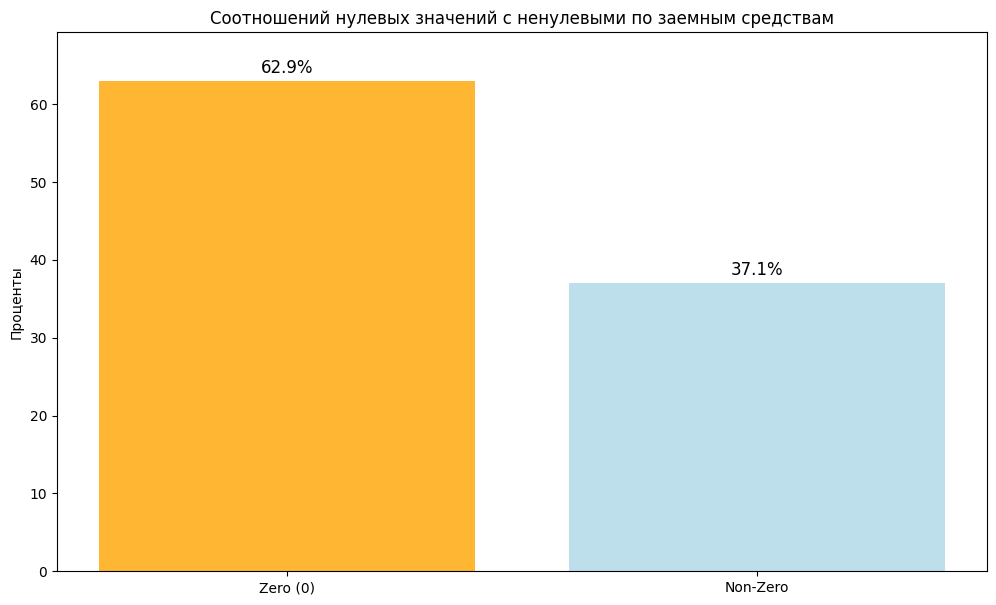

In [14]:
total = len(cleaned)
pct_zero = len(zeros) / total * 100
pct_non_zero = len(non_zeros) / total * 100

categories = ['Zero (0)', 'Non-Zero']
percentages = [pct_zero, pct_non_zero]

plt.figure(figsize=(12, 7))
bars = plt.bar(categories, percentages, color=['orange', 'lightblue'], alpha=0.8)

for bar, pct in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=12)

plt.ylabel('Проценты')
plt.title('Соотношений нулевых значений с ненулевыми по заемным средствам')
plt.ylim(0, max(percentages) * 1.1)  
plt.show()

Примем что отсутствующие значения - отсутствие заемных средств, чтобы не исключать колонку полностью.

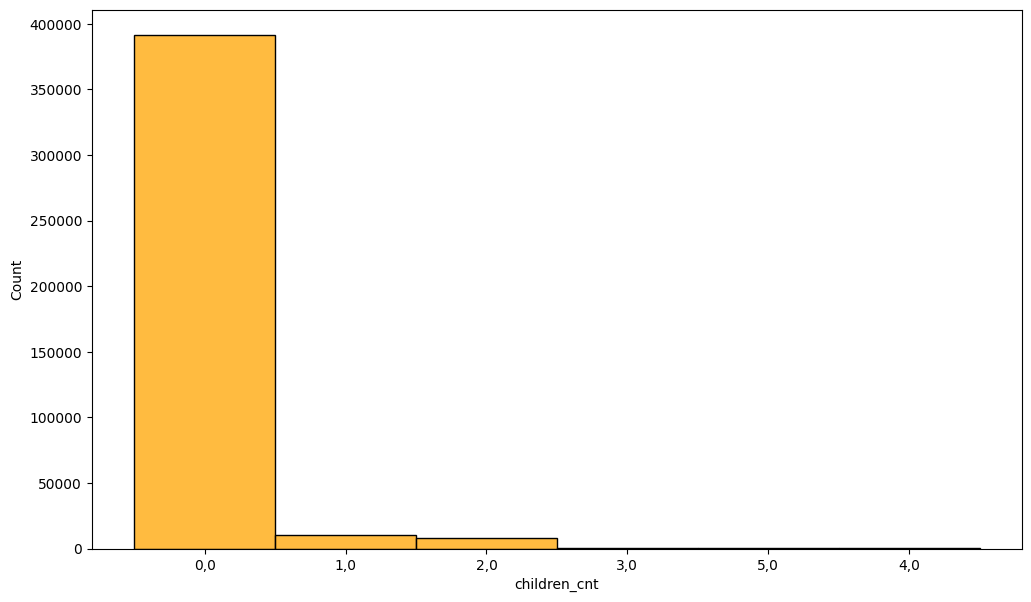

In [15]:
plt.figure(figsize=(12, 7))

sns.histplot(df['children_cnt'], color='orange')

plt.show()

In [16]:
df['education_level_cd'] = df['education_level_cd'].fillna('NAN')

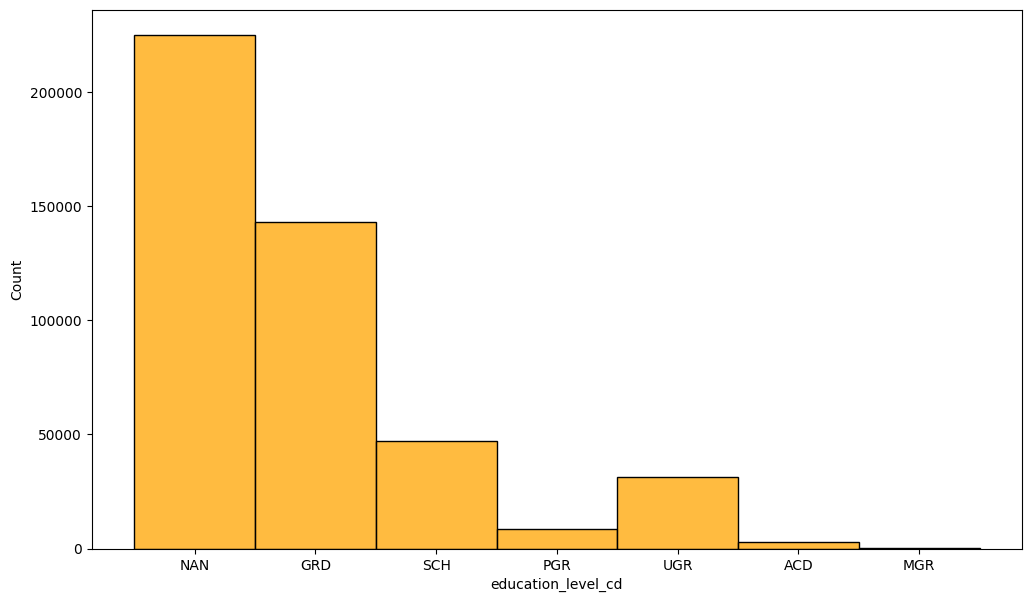

In [17]:
plt.figure(figsize=(12, 7))

sns.histplot(df['education_level_cd'], color='orange')

plt.show()

In [18]:
df['marital_status_cd'] = df['marital_status_cd'].fillna('NAN')

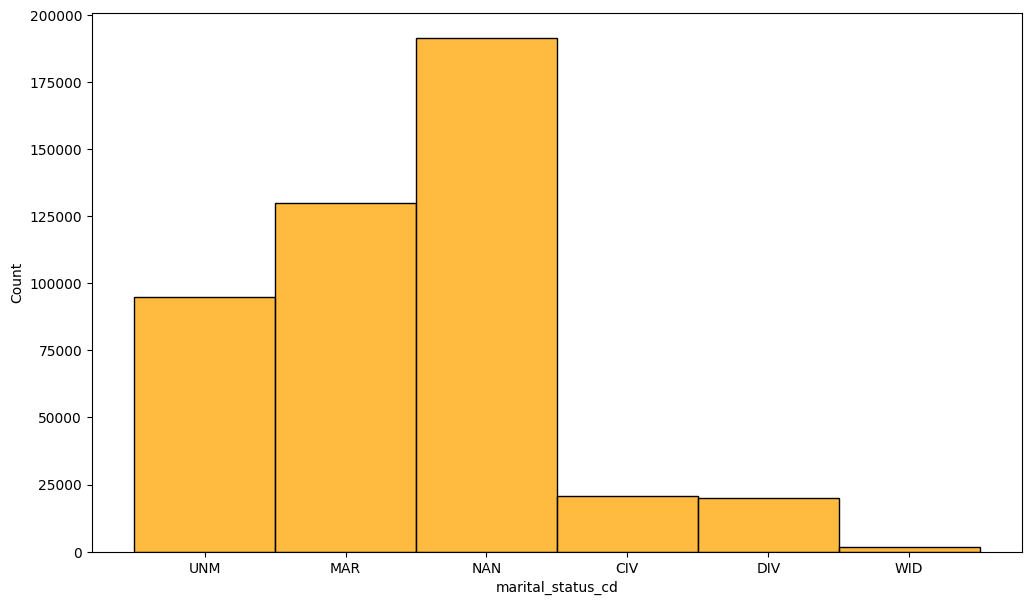

In [19]:
plt.figure(figsize=(12, 7))

sns.histplot(df['marital_status_cd'], color='orange')

plt.show()

In [20]:
print(len(df['id'].unique()))
print(len(df['id']))

5093
458370


In [21]:
cat_features = set(['forts_flg', 'margin_status_flg', 'qualified_investor_flg', 
 'invest_utilization_dt', 'marital_status_cd', 'education_level_cd', 'date', 'id'])

num_features = list(set(df.columns) - cat_features)

num_features

['children_cnt',
 'reads',
 'turnover_ore_sel_amt',
 'portf_opt_amt',
 'trade_order_opt_cnt',
 'portf_mex_amt',
 'age',
 'trade_order_cur_cnt',
 'reacts',
 'initial_margin_amt',
 'trade_order_rus_sec_cnt',
 'cor_balance_amt',
 'trade_order_ore_prc_cnt',
 'turnover_rus_bon_amt',
 'turnover_etf_amt',
 'portf_rus_bon_amt',
 'ccr_balance_amt',
 'posts',
 'turnover_ore_prc_amt',
 'uncovered_position_amt',
 'turnover_fnd_amt',
 'out_payment_rub_amt',
 'trade_order_rus_bon_cnt',
 'portf_ore_amt',
 'turnover_cur_amt',
 'turnover_opt_amt',
 'portf_cur_amt',
 'trade_order_forts_cnt',
 'portf_etf_amt',
 'portf_rus_sec_amt',
 'trade_order_ore_sel_cnt',
 'lon_balance_amt',
 'turnover_forts_amt',
 'trade_order_tracking_cnt',
 'trade_order_fnd_cnt',
 'portf_fnd_amt',
 'trade_order_etf_cnt',
 'comments',
 'portf_total_amt',
 'turnover_rus_sec_amt',
 'turnover_tracking_amt',
 'monthly_income_amt',
 'in_payment_rub_amt']

In [22]:
missing_percent = round((df.isna().sum() / len(df)) * 100, 2)
missing_percent = missing_percent[missing_percent > 0]

missing_percent

children_cnt          10.48
monthly_income_amt    22.52
ccr_balance_amt       36.44
cor_balance_amt        0.23
lon_balance_amt       67.60
posts                  4.21
comments               4.21
reacts                 4.21
reads                  4.21
dtype: float64

In [23]:
df[['posts', 'comments', 'reacts', 'reads']] = df[['posts', 'comments', 'reacts', 'reads']].fillna('-1,0')

In [24]:
columns = ['posts', 'comments', 'reacts', 'reads']
for col in columns:
    df[col] = df[col].astype(str).str.replace(',0', '', regex=False).astype(int)

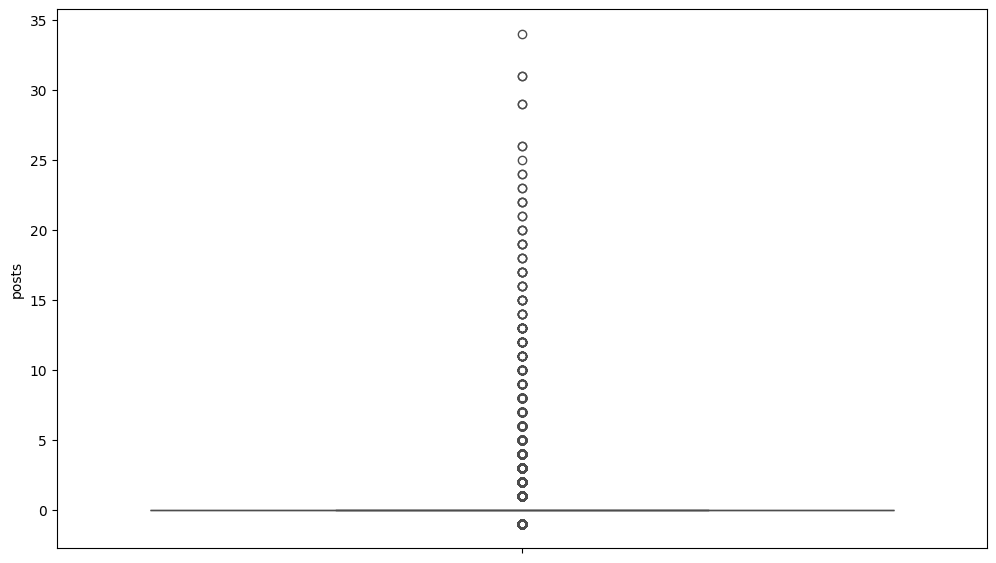

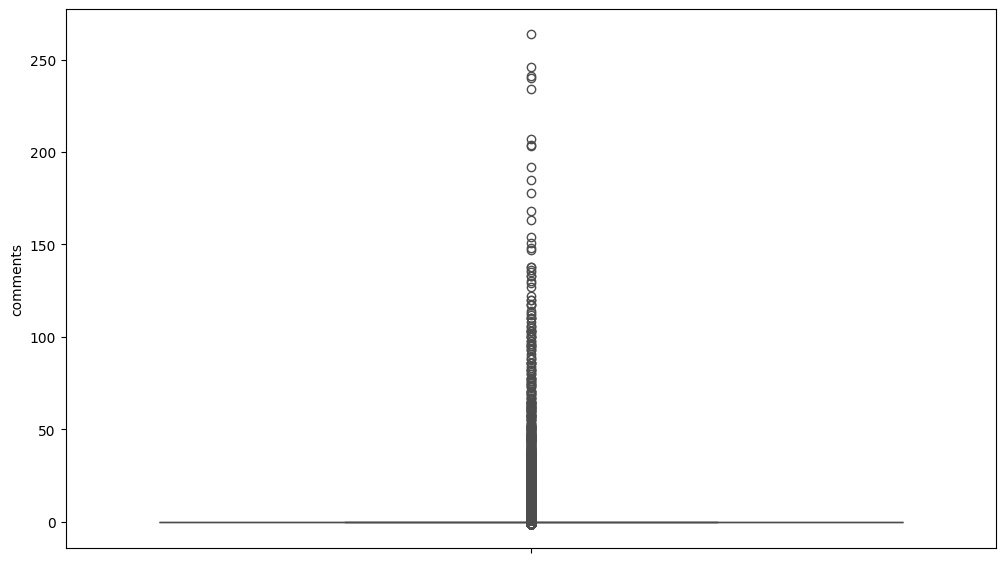

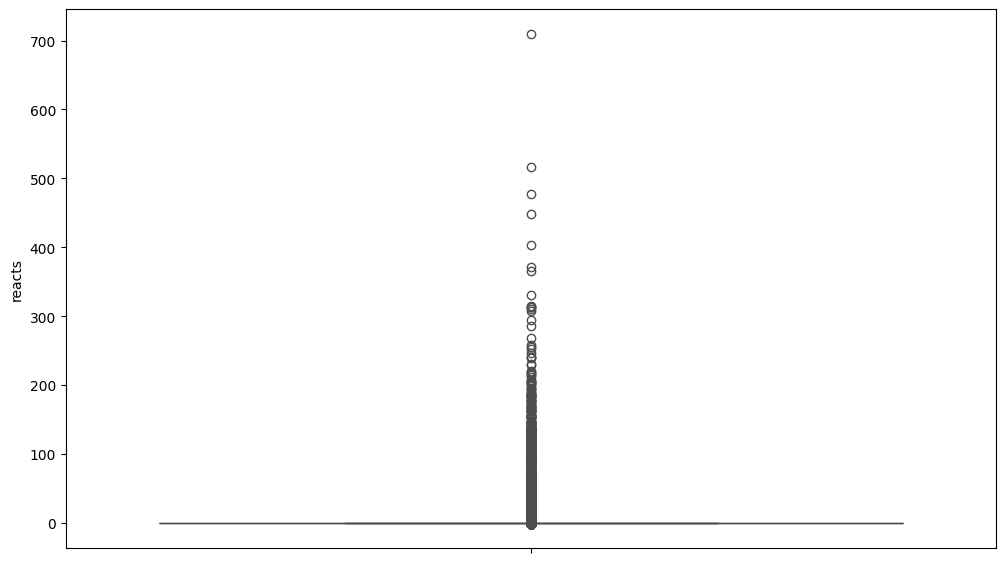

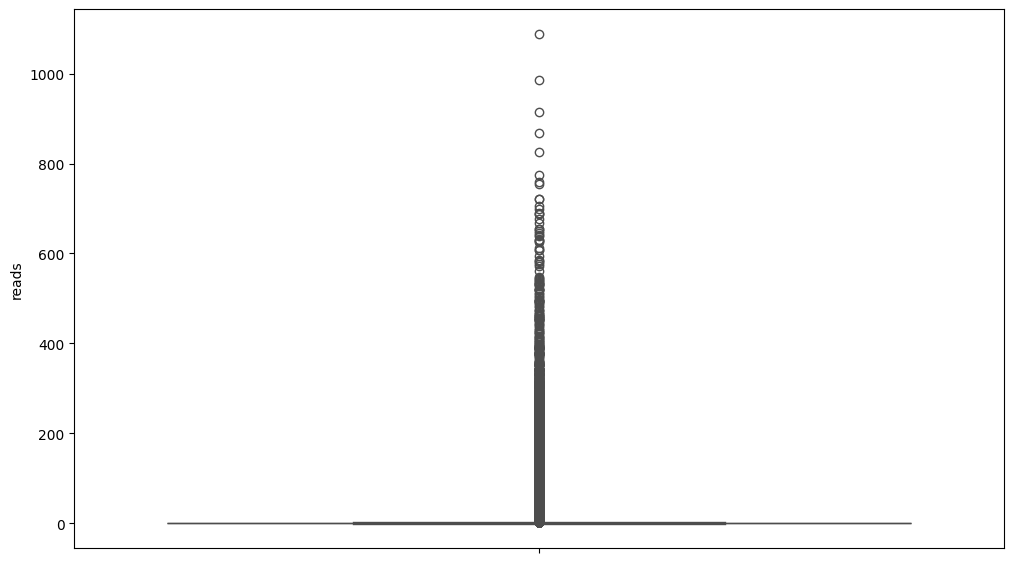

In [25]:
for col in columns:
    plt.figure(figsize=(12, 7))
    sns.boxplot(df[col], color='orange')

plt.show()

In [26]:
for col in num_features:
    # non_null_mask = df[col].notna() 

    df[col] = (
        df[col]
        .astype(str)
        .str.replace(',0', '', regex=False)
        .astype(float)
    ).astype(float)

In [27]:
df['portf_etf_amt']

0            643.0
1              0.0
2             22.0
3              0.0
4            219.0
            ...   
458365        19.0
458366        81.0
458367    162785.0
458368         0.0
458369       121.0
Name: portf_etf_amt, Length: 458370, dtype: float64

In [28]:
missing_percent = round((df.isna().sum() / len(df)) * 100, 2)
missing_percent = missing_percent[missing_percent > 0]

missing_percent

children_cnt          10.48
monthly_income_amt    22.52
ccr_balance_amt       36.44
cor_balance_amt        0.23
lon_balance_amt       67.60
dtype: float64

In [29]:
df.dropna(subset=['cor_balance_amt', 'ccr_balance_amt'])

,id,date,age,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,invest_utilization_dt,forts_flg,margin_status_flg,...,portf_fnd_amt,portf_opt_amt,portf_ore_amt,ccr_balance_amt,cor_balance_amt,lon_balance_amt,posts,comments,reacts,reads
0,1479787897,2024-04-20,33.0,NAN,UNM,0.0,31272.0,2023-09-13,1,0,...,428.0,0.0,0.0,-11298.0,541.0,0.0,0.0,0.0,0.0,0.0
2,61175329,2024-02-10,38.0,SCH,MAR,0.0,1904.0,2023-12-05,1,0,...,193.0,0.0,0.0,0.0,25.0,NaN,0.0,0.0,0.0,2.0
4,2096755145,2024-02-10,31.0,NAN,UNM,0.0,NaN,2022-03-01,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
5,1079261029,2024-04-22,36.0,GRD,MAR,0.0,3158.0,2020-04-01,0,0,...,77.0,0.0,0.0,0.0,677.0,NaN,0.0,0.0,0.0,0.0
6,2027433884,2024-03-14,44.0,PGR,UNM,0.0,2690.0,2023-12-14,0,0,...,5.0,0.0,0.0,-126733.0,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458361,1245124909,2024-03-27,67.0,GRD,MAR,0.0,2225.0,2021-09-03,1,0,...,0.0,0.0,0.0,-19097.0,16.0,-66245.0,0.0,0.0,0.0,0.0
458364,186294672,2024-04-11,37.0,NAN,NAN,0.0,1599.0,2020-08-07,0,0,...,3459.0,0.0,0.0,-5394.0,33733.0,NaN,0.0,0.0,0.0,3.0
458366,1903825748,2024-02-19,46.0,NAN,NAN,0.0,2524.0,2020-12-10,1,0,...,429.0,0.0,0.0,0.0,5068.0,NaN,0.0,0.0,0.0,6.0
458367,1825570440,2024-03-21,49.0,GRD,MAR,0.0,6267.0,2021-03-11,1,1,...,467.0,0.0,0.0,0.0,280.0,NaN,0.0,0.0,0.0,7.0


In [30]:
291253 / 458370 * 100

63.54102580884439

lon_balance_amt Эту колонку мы либо вообще не можем использовать, либо необходимо проверить, может ли быть так, что отсустствующее значение означает, что пользователь к тому моменту не занимал средства -> можно заполнить нулями.

Распределение значений в lon_balance_amt:
count    1.485030e+05
mean    -1.631091e+05
std      7.205143e+05
min     -1.483901e+07
25%     -3.522100e+04
50%      0.000000e+00
75%      0.000000e+00
max      2.910000e+02
Name: lon_balance_amt, dtype: float64

Количество пропусков: 309867
Процент пропусков: 67.6%

Количество записей с ненулевыми заемными средствами: 3924

Связь заемных средств с маржинальной торговлей:
has_positive_loan   False  True 
margin_status_flg               
0                  307839   2662
1                  146607   1262

Пользователей с маржинальной торговлей но без заемных средств: 671
Записей с маржинальной торговлей но без заемных средств: 52116

Пользователей с заемными средствами но без маржинальной торговли: 62
Записей с заемными средствами но без маржинальной торговли: 2662

Корреляция с другими показателями (только для положительных значений):
lon_balance_amt           1.000000
initial_margin_amt        0.083222
uncovered_position_amt    0.078452
portf_

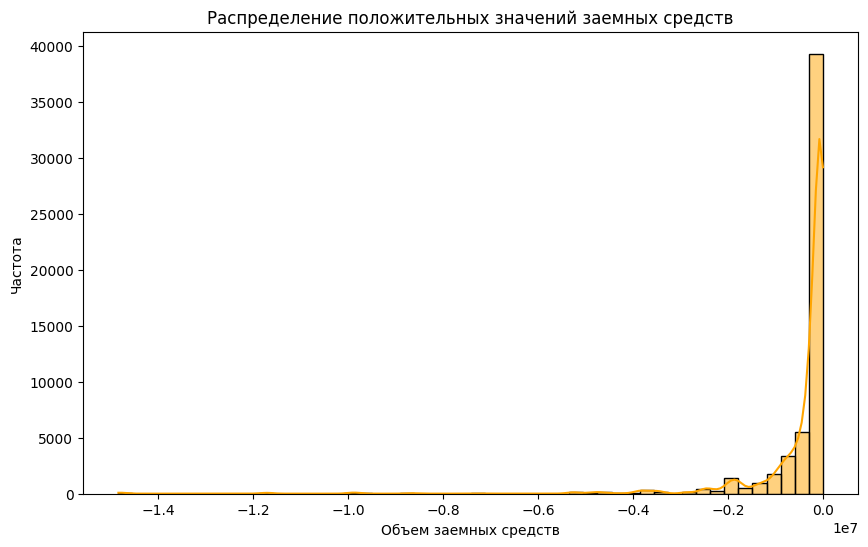


Количество отрицательных значений: 51108
Статистика отрицательных значений:
count    5.110800e+04
mean    -4.739432e+05
std      1.166684e+06
min     -1.483901e+07
25%     -4.052980e+05
50%     -1.115020e+05
75%     -3.189500e+04
max     -4.900000e+01
Name: lon_balance_amt, dtype: float64
Уникальных пользователей с отрицательными значениями: 698

Количество нулевых значений: 93471
Уникальных пользователей с нулевыми значениями: 1162

Пользователей, использовавших заемные средства (положительные): 364899
Уникальных пользователей с положительными заемными средствами: 4164


In [31]:
print("Распределение значений в lon_balance_amt:")
print(df['lon_balance_amt'].describe())
print(f"\nКоличество пропусков: {df['lon_balance_amt'].isnull().sum()}")
print(f"Процент пропусков: {df['lon_balance_amt'].isnull().mean() * 100:.1f}%")

non_zero_loan_mask = (df['lon_balance_amt'] > 0)
print(f"\nКоличество записей с ненулевыми заемными средствами: {non_zero_loan_mask.sum()}")

print("\nСвязь заемных средств с маржинальной торговлей:")
print(pd.crosstab(df['margin_status_flg'], non_zero_loan_mask, 
                  rownames=['margin_status_flg'], 
                  colnames=['has_positive_loan']))

margin_users_no_loan = df[(df['margin_status_flg'] == 1) & (df['lon_balance_amt'] <= 0)]
print(f"\nПользователей с маржинальной торговлей но без заемных средств: {margin_users_no_loan['id'].nunique()}")
print(f"Записей с маржинальной торговлей но без заемных средств: {len(margin_users_no_loan)}")

loan_without_margin = df[(df['lon_balance_amt'] > 0) & (df['margin_status_flg'] == 0)]
print(f"\nПользователей с заемными средствами но без маржинальной торговли: {loan_without_margin['id'].nunique()}")
print(f"Записей с заемными средствами но без маржинальной торговли: {len(loan_without_margin)}")

print("\nКорреляция с другими показателями (только для положительных значений):")
positive_loans = df[df['lon_balance_amt'] > 0]
correlation_cols = ['initial_margin_amt', 'uncovered_position_amt', 'portf_total_amt', 'turnover_forts_amt']
correlation = positive_loans[['lon_balance_amt'] + correlation_cols].corr()
print(correlation['lon_balance_amt'])

forts_users_no_loan = df[(df['turnover_forts_amt'] > 0) & (df['lon_balance_amt'] <= 0)]
print(f"\nПользователей с операциями на срочном рынке но без заемных средств: {forts_users_no_loan['id'].nunique()}")
print(f"Записей с операциями на срочном рынке но без заемных средств: {len(forts_users_no_loan)}")

plt.figure(figsize=(10, 6))
sns.histplot(df[df['lon_balance_amt'] != 0]['lon_balance_amt'], bins=50, kde=True, color='orange')
plt.title('Распределение положительных значений заемных средств')
plt.xlabel('Объем заемных средств')
plt.ylabel('Частота')
plt.show()

print(f"\nКоличество отрицательных значений: {(df['lon_balance_amt'] < 0).sum()}")
if (df['lon_balance_amt'] < 0).sum() > 0:
    negative_loans = df[df['lon_balance_amt'] < 0]
    print("Статистика отрицательных значений:")
    print(negative_loans['lon_balance_amt'].describe())
    print(f"Уникальных пользователей с отрицательными значениями: {negative_loans['id'].nunique()}")

zero_loans = df[df['lon_balance_amt'] == 0]
print(f"\nКоличество нулевых значений: {len(zero_loans)}")
print(f"Уникальных пользователей с нулевыми значениями: {zero_loans['id'].nunique()}")

df['has_positive_loan'] = (df['lon_balance_amt'] != 0).astype(int)
print(f"\nПользователей, использовавших заемные средства (положительные): {df['has_positive_loan'].sum()}")
print(f"Уникальных пользователей с положительными заемными средствами: {df[df['has_positive_loan'] == 1]['id'].nunique()}")

In [32]:
missing_records = df[df['lon_balance_amt'].isna()]

users_with_missing = missing_records['id'].unique()
users_with_loans_ever = df[(df['id'].isin(users_with_missing)) & 
                          (df['lon_balance_amt'].notna()) & 
                          (df['lon_balance_amt'] != 0)]['id'].unique()

print(f"Пользователей с пропусками, которые когда-либо имели заемные средства: {len(users_with_loans_ever)}")
print(f"Процент от всех пользователей с пропусками: {len(users_with_loans_ever) / len(users_with_missing) * 100:.1f}%")

Пользователей с пропусками, которые когда-либо имели заемные средства: 70
Процент от всех пользователей с пропусками: 2.0%


In [33]:
df['lon_balance_amt'] = df['lon_balance_amt'].fillna(0)

In [34]:
df[df['lon_balance_amt'] != 0]['lon_balance_amt'].abs()

11          22545.0
17         736071.0
23         416794.0
27          10881.0
42         213546.0
            ...    
458341      94289.0
458348    1938790.0
458360          3.0
458361      66245.0
458368      34401.0
Name: lon_balance_amt, Length: 55032, dtype: float64

In [35]:
n_df = df.select_dtypes(include=np.number)
corr = n_df.corr()

In [36]:
threshold = 0.2

high_corr_mask = corr.abs() > threshold

high_corr_mask = high_corr_mask & (np.triu(np.ones_like(high_corr_mask), k=1).astype(bool))

high_corr_pairs = corr.stack()[high_corr_mask.stack()].reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

high_corr_pairs['abs_corr'] = high_corr_pairs['Correlation'].abs()
high_corr_pairs = high_corr_pairs.sort_values('abs_corr', ascending=False).drop('abs_corr', axis=1)

high_corr_pairs.head(25)

,Variable 1,Variable 2,Correlation
33,portf_total_amt,portf_rus_bon_amt,0.872513
12,uncovered_position_amt,portf_cur_amt,0.815408
43,comments,reacts,0.752355
36,portf_mex_amt,portf_rus_sec_amt,0.648212
32,portf_total_amt,portf_mex_amt,0.622152
28,trade_order_etf_cnt,trade_order_tracking_cnt,0.618089
37,portf_mex_amt,portf_rus_bon_amt,0.603979
2,forts_flg,qualified_investor_flg,0.596950
40,posts,comments,0.518221
14,turnover_rus_sec_amt,initial_margin_amt,0.475105


In [37]:
n_df.columns

Index(['id', 'age', 'children_cnt', 'monthly_income_amt', 'forts_flg',
       'margin_status_flg', 'qualified_investor_flg', 'in_payment_rub_amt',
       'out_payment_rub_amt', 'uncovered_position_amt', 'turnover_rus_bon_amt',
       'turnover_rus_sec_amt', 'turnover_forts_amt', 'turnover_cur_amt',
       'turnover_etf_amt', 'turnover_fnd_amt', 'turnover_opt_amt',
       'turnover_ore_prc_amt', 'turnover_ore_sel_amt', 'turnover_tracking_amt',
       'trade_order_rus_sec_cnt', 'trade_order_rus_bon_cnt',
       'trade_order_forts_cnt', 'trade_order_cur_cnt', 'trade_order_etf_cnt',
       'trade_order_fnd_cnt', 'trade_order_opt_cnt', 'trade_order_ore_prc_cnt',
       'trade_order_ore_sel_cnt', 'trade_order_tracking_cnt',
       'portf_total_amt', 'portf_mex_amt', 'portf_rus_sec_amt',
       'portf_rus_bon_amt', 'initial_margin_amt', 'portf_cur_amt',
       'portf_etf_amt', 'portf_fnd_amt', 'portf_opt_amt', 'portf_ore_amt',
       'ccr_balance_amt', 'cor_balance_amt', 'lon_balance_amt', 'p

In [38]:
df = df.sort_values(['id', 'date'])

df['daily_return'] = df.groupby('id')['portf_total_amt'].pct_change()

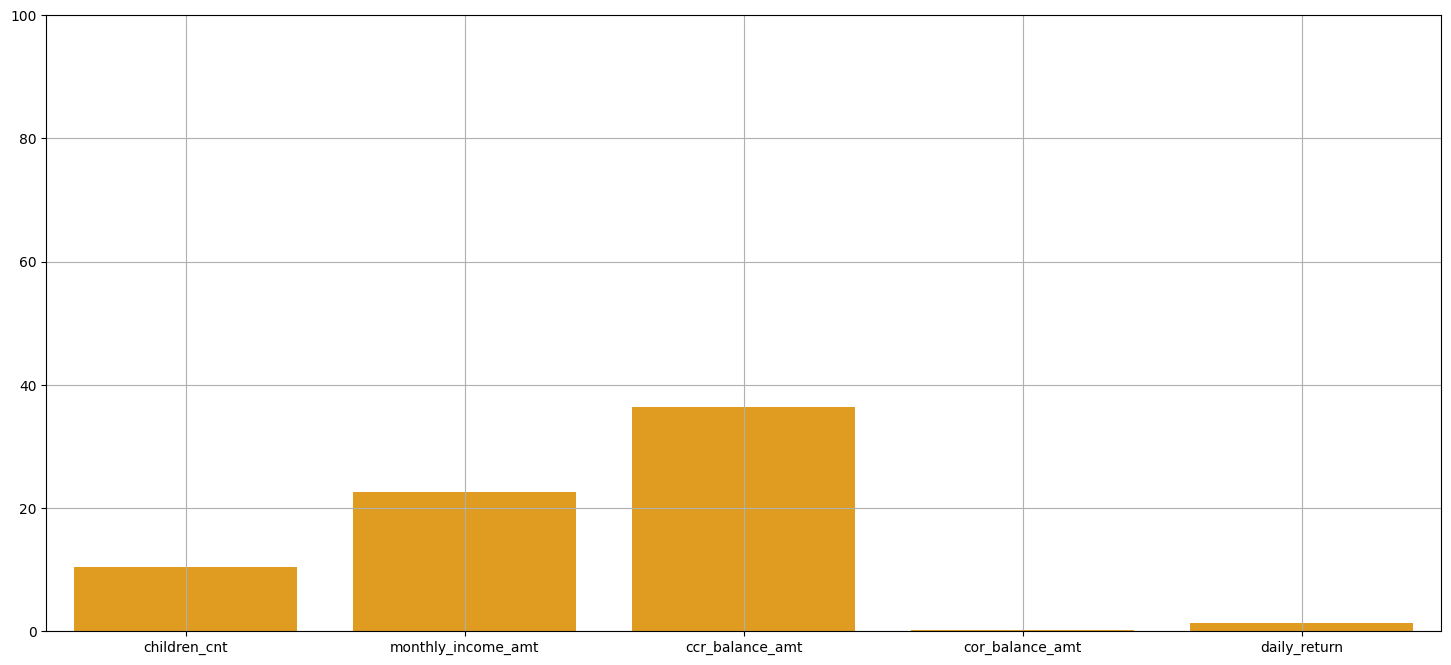

In [39]:
missing_percent = round((df.isna().sum() / len(df)) * 100, 2)
missing_percent = missing_percent[missing_percent > 0]

plt.figure(figsize=(18, 8))

sns.barplot(missing_percent, color='orange')

plt.ylim(0, 100)
plt.grid()
plt.show()

In [40]:
columns_to_fill = ['children_cnt', 'monthly_income_amt', 'ccr_balance_amt', 'cor_balance_amt']

for column in columns_to_fill:
    print(f"Заполняем пропуски в колонке {column}...")
    
    df[column] = df.groupby('id')[column].ffill()

    df[column] = df.groupby('id')[column].bfill()
    
    remaining_nans = df[column].isna().sum()
    print(f"Осталось пропусков в {column}: {remaining_nans} ({remaining_nans/len(df)*100:.2f}%)")

print("\nИтоговая статистика по пропускам после заполнения:")
for column in columns_to_fill:
    remaining_nans = df[column].isna().sum()
    print(f"{column}: {remaining_nans} пропусков ({remaining_nans/len(df)*100:.2f}%)")

Заполняем пропуски в колонке children_cnt...
Осталось пропусков в children_cnt: 48060 (10.48%)
Заполняем пропуски в колонке monthly_income_amt...
Осталось пропусков в monthly_income_amt: 103230 (22.52%)
Заполняем пропуски в колонке ccr_balance_amt...
Осталось пропусков в ccr_balance_amt: 162270 (35.40%)
Заполняем пропуски в колонке cor_balance_amt...
Осталось пропусков в cor_balance_amt: 810 (0.18%)

Итоговая статистика по пропускам после заполнения:
children_cnt: 48060 пропусков (10.48%)
monthly_income_amt: 103230 пропусков (22.52%)
ccr_balance_amt: 162270 пропусков (35.40%)
cor_balance_amt: 810 пропусков (0.18%)


In [41]:
df['children_cnt_missing'] = df['children_cnt'].isna().astype(int)
df['monthly_income_missing'] = df['monthly_income_amt'].isna().astype(int)
df['ccr_balance_missing'] = df['ccr_balance_amt'].isna().astype(int)
df['monthly_income_amt'] = df['monthly_income_amt'].isna().astype(int)

df['cor_balance_amt'] = df['cor_balance_amt'].fillna(df['cor_balance_amt'].median())
df['monthly_income_amt'] = df['monthly_income_amt'].fillna(df['monthly_income_amt'].median())
df['ccr_balance_amt'] = df['ccr_balance_amt'].fillna(0)
df['children_cnt'] = df['children_cnt'].fillna(0)

In [42]:
missing_percent = round((df.isna().sum() / len(df)) * 100, 2)
missing_percent = missing_percent[missing_percent > 0]

missing_percent

daily_return    1.33
dtype: float64

Все критичные пропуски устранены.

# Анализ идеальных клиентов

In [ ]:
from sklearn.preprocessing import StandardScaler

client_features = df.groupby('id').agg({
    'turnover_rus_sec_amt': 'sum',
    'turnover_rus_bon_amt': 'sum', 
    'turnover_forts_amt': 'sum',
    'turnover_etf_amt': 'sum',
    'turnover_cur_amt': 'sum',
    
    'portf_total_amt': ['mean', 'max'],
    
    'margin_status_flg': 'max',
    'forts_flg': 'max',
    'qualified_investor_flg': 'max',
    'lon_balance_amt': 'max',
    
    'age': 'last',
    'education_level_cd': 'last',
    'monthly_income_amt': 'last',
    
    'posts': 'sum',
    'comments': 'sum',
    'reacts': 'sum',
    'reads': 'sum'
})

client_features.columns = ['_'.join(col).strip() for col in client_features.columns.values]
client_features = client_features.reset_index()

client_features['total_turnover'] = (
    client_features['turnover_rus_sec_amt_sum'] +
    client_features['turnover_rus_bon_amt_sum'] +
    client_features['turnover_forts_amt_sum'] +
    client_features['turnover_etf_amt_sum'] +
    client_features['turnover_cur_amt_sum']
)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(client_features.select_dtypes(include=[np.number]).fillna(0))

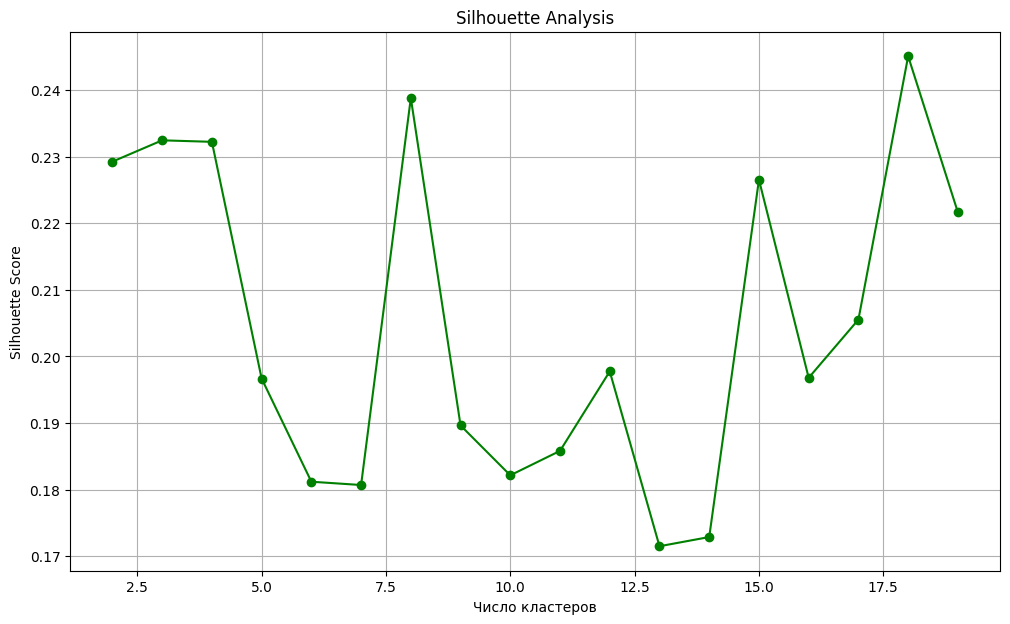

In [44]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(12, 7))
plt.plot(range(2, 20), silhouette_scores, 'go-')
plt.xlabel('Число кластеров')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.show()

Будем использовать 3 кластера, чтоб не слишком много, с нормальным при этом силуэтом. Отхватить самых идеальных скорее всего хватит

In [45]:
kmeans = KMeans(n_clusters=3, random_state=42)
client_features['cluster'] = kmeans.fit_predict(scaled_features)

cluster_stats = client_features.groupby('cluster').agg({
    'total_turnover': 'mean',
    'portf_total_amt_mean': 'mean',
    'margin_status_flg_max': 'mean',
    'forts_flg_max': 'mean'
}).round(2)

print("Статистика по кластерам:")
cluster_stats

Статистика по кластерам:


,total_turnover,portf_total_amt_mean,margin_status_flg_max,forts_flg_max
cluster,,,,
0,1365329.80,158721.38,0.67,1.00
1,80035.76,13070.34,0.24,0.37
2,58940.76,17220.73,0.14,0.27


In [46]:
ideal_cluster = cluster_stats['total_turnover'].idxmax()
client_features['is_ideal'] = (client_features['cluster'] == ideal_cluster).astype(int)

print(f"\nИдеальный кластер: {ideal_cluster}")
print(f"Количество идеальных клиентов: {client_features['is_ideal'].sum()}")
print(f"Доля идеальных клиентов: {client_features['is_ideal'].mean()*100:.2f}%")


Идеальный кластер: 0
Количество идеальных клиентов: 1635
Доля идеальных клиентов: 32.10%


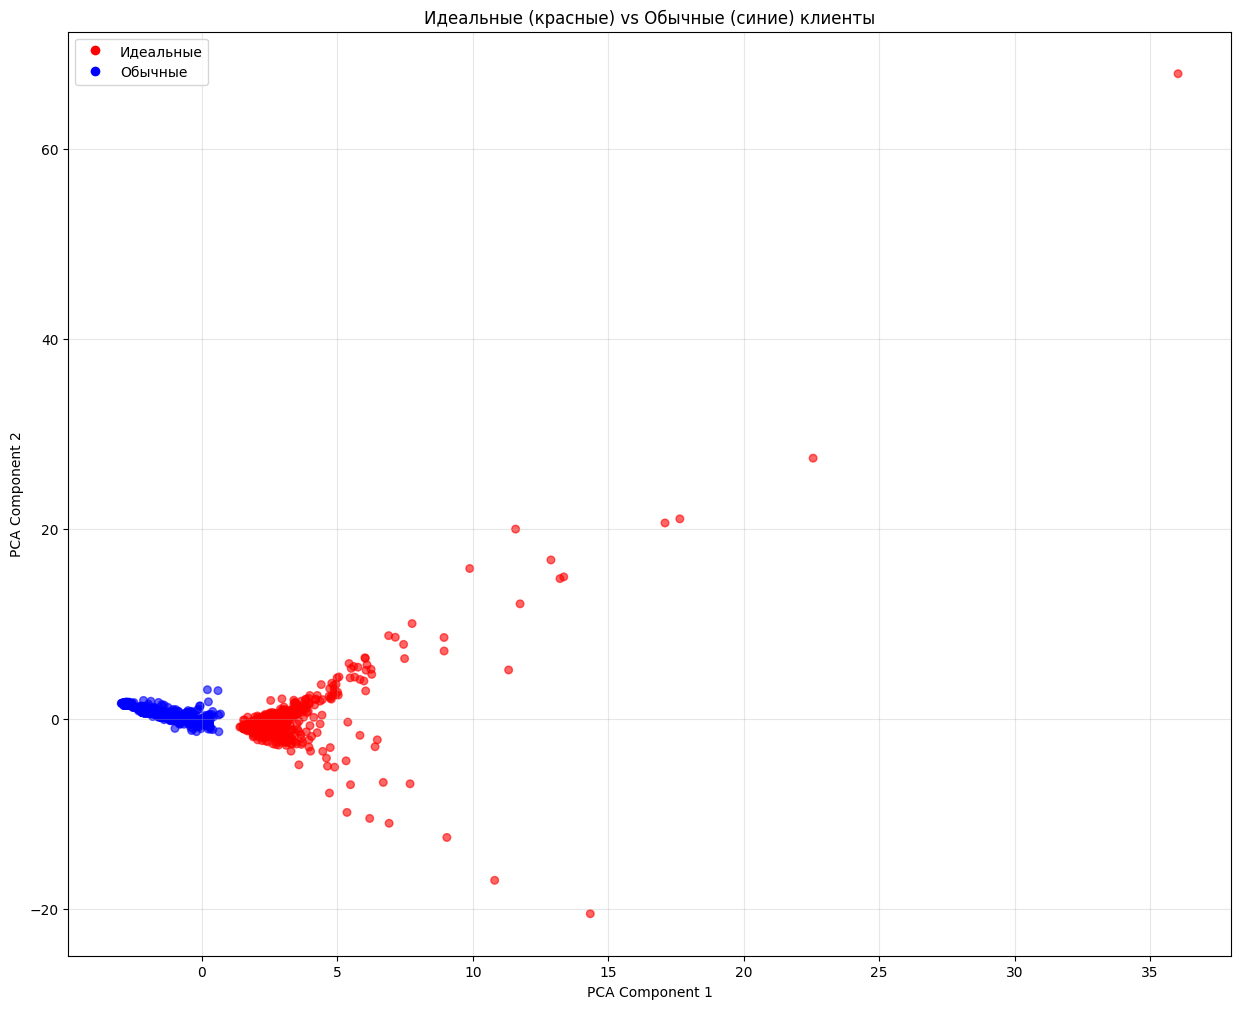

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = client_features.select_dtypes(include=np.number).columns

X = client_features[numeric_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 12))

colors = ['red' if ideal else 'blue' for ideal in client_features['is_ideal']]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, s=30)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Идеальные (красные) vs Обычные (синие) клиенты')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Идеальные'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Обычные')])
plt.grid(True, alpha=0.3)
plt.show()

In [48]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)

print("Метрики качества кластеризации:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

Метрики качества кластеризации:
Silhouette Score: 0.358
Calinski-Harabasz Index: 858.384
Davies-Bouldin Index: 1.312


In [49]:
high_turnover_non_ideal = client_features[
    (client_features['total_turnover'] > 100000) & 
    (client_features['is_ideal'] == 0)
].sort_values('total_turnover', ascending=False)

print("Клиенты с высокими оборотами, но не идеальные:")
print(high_turnover_non_ideal[['id', 'total_turnover', 'cluster', 'margin_status_flg_max', 
                              'forts_flg_max', 'qualified_investor_flg_max']].head(10))

low_turnover_ideal = client_features[
    (client_features['total_turnover'] < 50000) & 
    (client_features['is_ideal'] == 1)
].sort_values('total_turnover')

print("\nКлиенты с низкими оборотами, но идеальные:")
print(low_turnover_ideal[['id', 'total_turnover', 'cluster', 'margin_status_flg_max', 
                         'forts_flg_max', 'qualified_investor_flg_max']].head(10))

Клиенты с высокими оборотами, но не идеальные:
              id  total_turnover  cluster  margin_status_flg_max  \
2304   951182765       6743909.0        1                      1   
1103   450363218       6638323.0        1                      1   
1503   628740097       6248111.0        1                      1   
4598  1920826579       5288642.0        1                      1   
4101  1725410380       4943085.0        2                      0   
3354  1404449724       4772499.0        1                      1   
1886   782409951       4743769.0        1                      1   
940    380685053       3949883.0        1                      1   
5042  2125441114       3718824.0        1                      0   
2579  1066171469       3527570.0        1                      1   

      forts_flg_max  qualified_investor_flg_max  
2304              0                           0  
1103              0                           0  
1503              0                           0  
4598

In [50]:
new_weights = {
    'total_turnover': 0.25,           
    'portf_total_amt_mean': 0.20,     
    'margin_status_flg_max': 0.15,    
    'forts_flg_max': 0.15,            
    'qualified_investor_flg_max': 0.10, 
    'in_payment_rub_amt_sum': 0.15    
}

client_features['new_ideal_score'] = 0
for feature, weight in new_weights.items():
    if feature in client_features.columns:
        normalized = (client_features[feature] - client_features[feature].min()) / \
                     (client_features[feature].max() - client_features[feature].min())
        client_features['new_ideal_score'] += normalized * weight

new_ideal_threshold = client_features['new_ideal_score'].quantile(0.80)
client_features['new_is_ideal'] = (client_features['new_ideal_score'] >= new_ideal_threshold).astype(int)

comparison = pd.crosstab(client_features['is_ideal'], client_features['new_is_ideal'])
print("Сравнение старой и новой идеальности:")
print(comparison)

high_turnover_new_status = client_features[
    client_features['total_turnover'] > 1000000
][['id', 'total_turnover', 'is_ideal', 'new_is_ideal', 
   'qualified_investor_flg_max', 'forts_flg_max']]

print(f"\nВысокооборотные клиенты (>1M): {len(high_turnover_new_status)}")
print(f"Идеальные по старой метрике: {high_turnover_new_status['is_ideal'].sum()}")
print(f"Идеальные по новой метрике: {high_turnover_new_status['new_is_ideal'].sum()}")

Сравнение старой и новой идеальности:
new_is_ideal     0     1
is_ideal                
0             3458     0
1              616  1019

Высокооборотные клиенты (>1M): 358
Идеальные по старой метрике: 307
Идеальные по новой метрике: 261


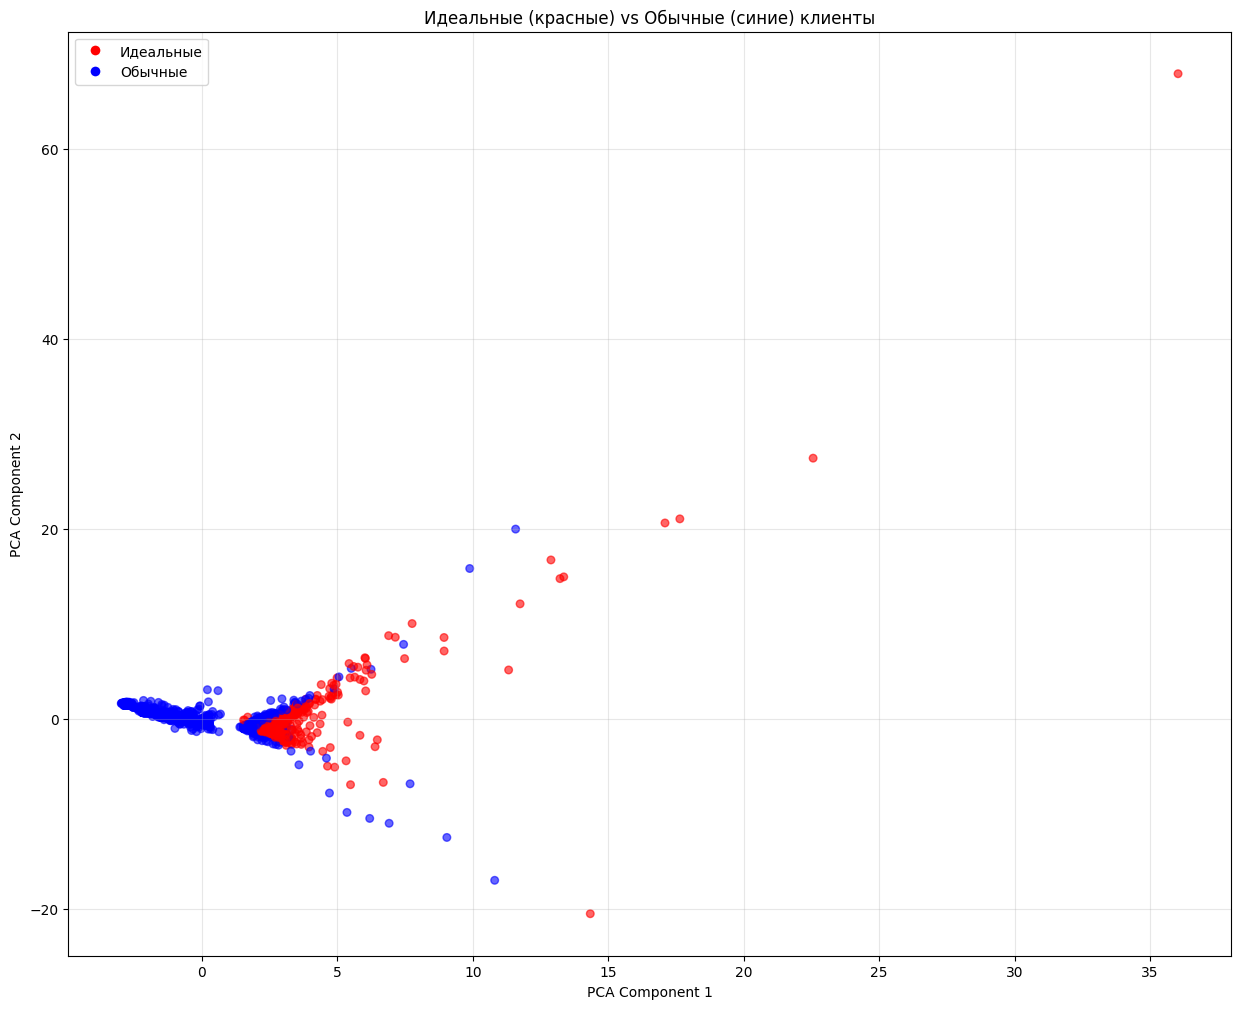

In [51]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 12))

colors = ['red' if ideal else 'blue' for ideal in client_features['new_is_ideal']]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, s=30)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Идеальные (красные) vs Обычные (синие) клиенты')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Идеальные'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Обычные')])
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
false_ideal = client_features[
    (client_features['is_ideal'] == 1) & 
    (client_features['new_is_ideal'] == 0)
]

true_ideal = client_features[client_features['new_is_ideal'] == 1]

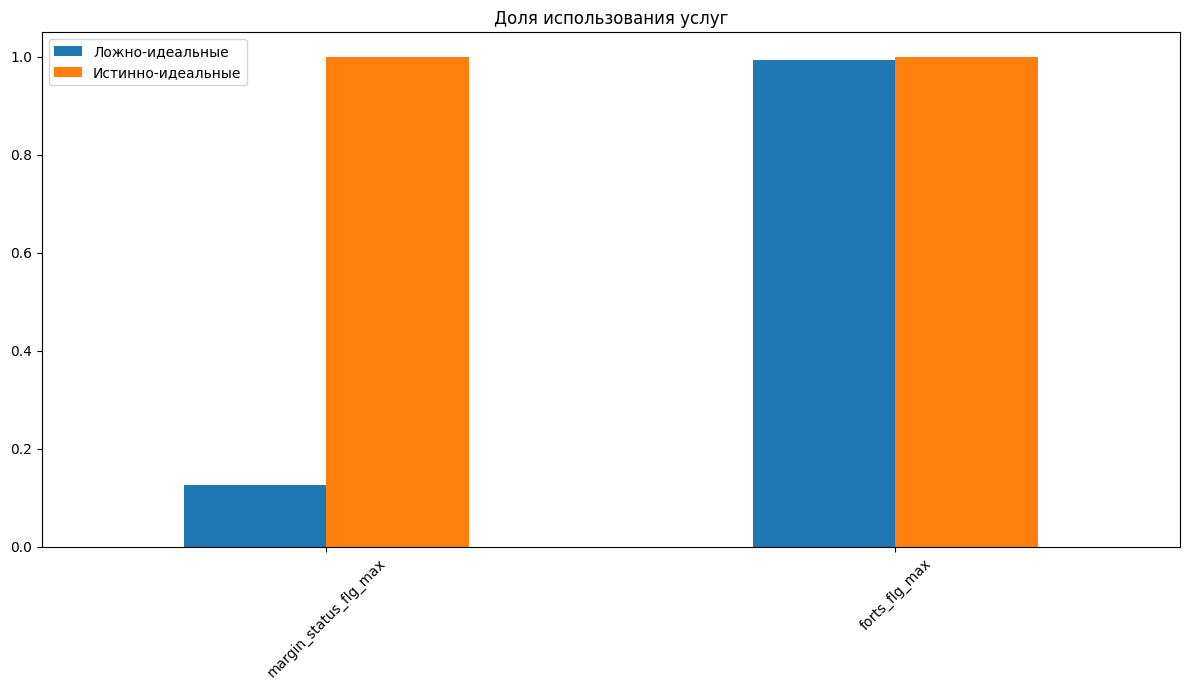

In [53]:
plt.figure(figsize=(12, 7))
services_comparison = pd.DataFrame({
    'Ложно-идеальные': false_ideal[['margin_status_flg_max', 'forts_flg_max']].mean(),
    'Истинно-идеальные': true_ideal[['margin_status_flg_max', 'forts_flg_max']].mean()
})
services_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Доля использования услуг')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [54]:
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
import numpy as np

client_features['group'] = client_features['new_is_ideal'].map({0: 'not_ideal', 1: 'ideal'})

numeric_features = [
    'turnover_rus_sec_amt_sum', 'turnover_rus_bon_amt_sum',
    'turnover_forts_amt_sum', 'turnover_etf_amt_sum',
    'turnover_cur_amt_sum', 'portf_total_amt_mean',
    'portf_total_amt_max', 'lon_balance_amt_max',
    'age_last', 'posts_sum', 'comments_sum', 'monthly_income_amt_last',
    'reacts_sum', 'reads_sum', 'total_turnover', 
]

categorical_features = [
    'margin_status_flg_max', 'forts_flg_max',
    'qualified_investor_flg_max'
]

from scipy.stats import ttest_ind

print("ПЕРЕСЧЕТ С T-TEST ДЛЯ 2 ГРУПП:")
print("=" * 50)

t_test_results = []
for feature in numeric_features:
    ideal_group = client_features[client_features['new_is_ideal'] == 1][feature]
    not_ideal_group = client_features[client_features['new_is_ideal'] == 0][feature]
    
    t_stat, p_value = ttest_ind(ideal_group, not_ideal_group, equal_var=False)  # Welch's t-test
    
    t_test_results.append({
        'Признак': feature,
        't-статистика': t_stat,
        'p-value': p_value
    })

t_test_df = pd.DataFrame(t_test_results)

t_test_df.sort_values('p-value').round(6)

ПЕРЕСЧЕТ С T-TEST ДЛЯ 2 ГРУПП:


,Признак,t-статистика,p-value
13,reads_sum,8.747515,0.000000
9,posts_sum,7.655701,0.000000
6,portf_total_amt_max,6.189439,0.000000
5,portf_total_amt_mean,6.163818,0.000000
8,age_last,5.455918,0.000000
14,total_turnover,5.435167,0.000000
2,turnover_forts_amt_sum,5.143952,0.000000
0,turnover_rus_sec_amt_sum,4.306656,0.000018
1,turnover_rus_bon_amt_sum,3.407026,0.000682
10,comments_sum,3.258187,0.001153


In [55]:
print("\nАНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")
print("=" * 60)

chi2_results = []
for feature in categorical_features:
    contingency_table = pd.crosstab(client_features[feature], client_features['new_is_ideal'])
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    usage_ideal = client_features[client_features['new_is_ideal'] == 1][feature].mean() * 100
    usage_not_ideal = client_features[client_features['new_is_ideal'] == 0][feature].mean() * 100
    
    chi2_results.append({
        'Признак': feature,
        'Хи-квадрат': chi2,
        'p-value': p_value,
        'Cramér\'s V': cramers_v,
        'Идеальные (%)': usage_ideal,
        'Неидеальные (%)': usage_not_ideal,
        'Разница (%)': abs(usage_ideal - usage_not_ideal)
    })

chi2_df = pd.DataFrame(chi2_results)
chi2_df['Стат. значимость'] = chi2_df['p-value'].apply(
    lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else ''
)

print("Результаты хи-квадрат тестов:")
chi2_df[['Признак', 'Хи-квадрат', 'p-value', 'Стат. значимость',
               'Cramér\'s V', 'Идеальные (%)', 'Неидеальные (%)']]


АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:
Результаты хи-квадрат тестов:


,Признак,Хи-квадрат,p-value,Стат. значимость,Cramér's V,Идеальные (%),Неидеальные (%)
0,margin_status_flg_max,2271.793018,0.000000e+00,***,0.667879,100.0,19.857634
1,forts_flg_max,1020.454963,6.428931e-224,***,0.447621,100.0,44.329897
2,qualified_investor_flg_max,2867.646387,0.000000e+00,***,0.750371,100.0,13.402062


In [56]:
plt.figure(figsize=(16, 12))

top_features = anova_df.nlargest(5, 'Размер эффекта (η²)')[['Признак', 'Размер эффекта (η²)']]
plt.subplot(2, 2, 1)
sns.barplot(x='Размер эффекта (η²)', y='Признак', data=top_features)
plt.title('Топ-5 признаков по размеру эффекта\n(Числовые признаки)')
plt.xlabel('η² (чем больше, тем сильнее различие)')

plt.subplot(2, 2, 2)
services_comparison = pd.DataFrame({
    'Идеальные': [100, 100, 100],
    'Неидеальные': [19.9, 44.3, 13.4]
}, index=['Маржинальная торговля', 'Срочный рынок', 'Квалиф. инвестор'])
services_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Использование услуг (%)')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=45)

ratios = []
for _, row in anova_df.iterrows():
    if row['Неидеальные (mean)'] != 0:
        ratio = row['Идеальные (mean)'] / row['Неидеальные (mean)']
        ratios.append({'Признак': row['Признак'], 'Отношение': ratio})

ratio_df = pd.DataFrame(ratios).nlargest(5, 'Отношение')
plt.subplot(2, 2, 3)
sns.barplot(x='Отношение', y='Признак', data=ratio_df)
plt.title('Отношение средних значений\n(Идеальные / Неидеальные)')
plt.xscale('log')  

plt.subplot(2, 2, 4)
significant_features = anova_df.nsmallest(10, 'p-value')
significant_features['-log10(p)'] = -np.log10(significant_features['p-value'])
sns.barplot(x='-log10(p)', y='Признак', data=significant_features)
plt.title('Статистическая значимость\n(-log10(p-value))')
plt.xlabel('Чем больше, тем значимее')

plt.tight_layout()
plt.show()

NameError: name 'anova_df' is not defined

<Figure size 1600x1200 with 0 Axes>

(array([0, 1, 2]),
 [Text(0, 0, 'Маржинальная торговля'),
  Text(1, 0, 'Срочный рынок'),
  Text(2, 0, 'Квалиф. инвестор')])

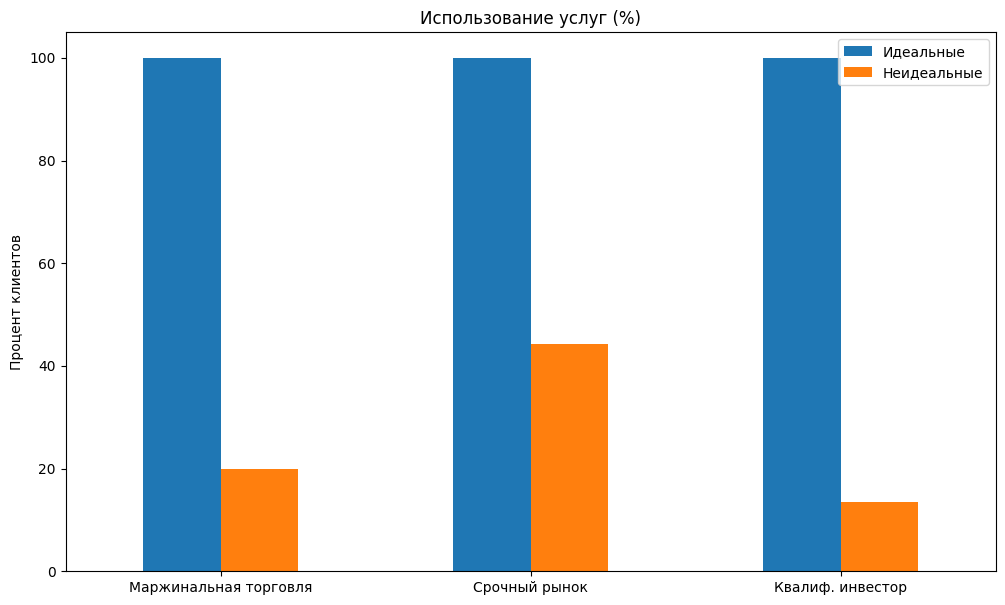

In [ ]:
plt.figure(figsize=(12, 7))
services_comparison = pd.DataFrame({
    'Идеальные': [100, 100, 100],
    'Неидеальные': [19.9, 44.3, 13.4]
}, index=['Маржинальная торговля', 'Срочный рынок', 'Квалиф. инвестор'])
services_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Использование услуг (%)')
plt.ylabel('Процент клиентов')
plt.xticks(rotation=360)

In [ ]:
client_features.drop(['is_ideal', 'cluster', 'new_ideal_score'], axis=1, inplace=True)

In [ ]:
correlation_with_ideal = client_features.select_dtypes(include=np.number).corr()['new_is_ideal'].sort_values(key=abs, ascending=False)
print("\nКорреляции с признаком 'идеальный клиент':")
print(correlation_with_ideal.head(11))


Корреляции с признаком 'идеальный клиент':
new_is_ideal                  1.000000
qualified_investor_flg_max    0.750903
margin_status_flg_max         0.668390
forts_flg_max                 0.448114
portf_total_amt_max           0.162388
portf_total_amt_mean          0.162030
reads_sum                     0.161403
total_turnover                0.142545
posts_sum                     0.129028
turnover_forts_amt_sum        0.119113
turnover_rus_sec_amt_sum      0.115393
Name: new_is_ideal, dtype: float64
